In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gp
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from adjustText import adjust_text

In [4]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"
cntry_info_path="../../data/nf_folder/Data/AdditionalData/country_metadata.csv"
flag_path='../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'

In [43]:
colldep_path='../../data/nf_folder/Figs/colldep.pdf'
fig_path='../../data/nf_folder/Figs/globalimpact.pdf'

In [5]:
paf = pd.read_pickle(pubs_path)

In [6]:
paf.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0


label out the internationally funded publications include co-funded publications and completely foreign funded publications

In [67]:
def assign_label(authors,funders):
    label=1 #indicates the paper is internationally funded and showed be removed
    if funders=='Not-Funded':
        label=0
    elif len(funders)==1 and funders[0] in authors:
        label=0
    return label
paf['label']=paf[['author_distinct','funder_distinct']
                ].apply(lambda x:assign_label(x.author_distinct,x.funder_distinct),axis=1)

In [90]:
#construct the raw profile of countries by fractional counting
def construct_profile(data):
    profile=[]
    for ind, row in data.iterrows():
        year=row['year']
        dis=row['discipline']
        authors=row['author_distinct']
        num_aut=len(authors) #pubs are fractionalized based on the countries
        for a in authors:
            profile.append([a,year,dis,1/num_aut])
    profile_df=pd.DataFrame(profile,columns=['cntry','year','dis','frac'])
    profile_df=profile_df.groupby(['cntry','year','dis'])['frac'].sum().reset_index()
    return profile_df

raw profile of countries in a dataframe structure

In [17]:
raw_p=construct_profile(paf)

the profile of countries after removed internationally funded pubs(label==1)

In [19]:
filter_df=paf[paf.label==0]
filter_p=construct_profile(filter_df)

output the raw and filtered profiles of countries

In [7]:
raw_p.to_csv("raw_profile.csv",index=False)
filter_p.to_csv("filter_profile.csv",index=False)

NameError: name 'raw_p' is not defined

In [7]:
raw_p=pd.read_csv('raw_profile.csv',dtype={'dis':'str'})
filter_p=pd.read_csv('filter_profile.csv',dtype={'dis':'str'})

In [79]:
raw_p[(raw_p.cntry=='China')&(raw_p.year==2009)]

,cntry,year,dis,frac
18735,China,2009,1,1815.612155
18736,China,2009,2,1879.160256
18737,China,2009,3,231.416667
18738,China,2009,4,318.646324
18739,China,2009,5,314.209524
...,...,...,...,...
18828,China,2009,96,7935.584455
18829,China,2009,97,90.166667
18830,China,2009,98,1100.846045
18831,China,2009,99,3067.250000


In [8]:
cnt_all=raw_p.groupby(by='cntry')['frac'].sum().reset_index(name='cnt_all')
cnt_filter = filter_p.groupby(by='cntry')['frac'].sum().reset_index(name='cnt_filter')
cnt_df=cnt_all.merge(cnt_filter,on='cntry',how='left')

In [9]:
cnt_df['prop']=(cnt_df['cnt_all']-cnt_df['cnt_filter'])/(cnt_df['cnt_all'])

get the discipline list to reorder the profile matrix columns

In [10]:
dislist = raw_p.dis.unique()
dislist.sort()

In [11]:
def get_dis_distribution(df,dislist):
    #group the profile from paper level to country level
    result_df=df.groupby(['cntry','dis'])['frac'].sum().reset_index()
    #reshape the country level long to wide format
    result_df=result_df.pivot_table(index='cntry',columns='dis',values='frac',fill_value=0)
    #reorder the columns of the matrix
    result_df=result_df[dislist]
    #row normalization
    result_df=result_df.div(result_df.sum(axis=1), axis=0)
    return result_df

In [12]:
raw_p = get_dis_distribution(raw_p,dislist)
filter_p=get_dis_distribution(filter_p,dislist)

In [13]:
def cal_kl(P,Q):
    sum=0
    for ind,item in enumerate(P):
        value_p=P[ind]
        value_q=Q[ind]
        if value_p!=0 and value_q!=0:
            sum=sum+(value_p*np.log(value_p/value_q))
    return sum

In [14]:
def kl_cntrys(pmatrix, qmatrix,colname):
    result=[]
    for index, row in pmatrix.iterrows():
        cntry=index
        p=row.values
        q=qmatrix.loc[cntry,:].values
        kl_value=cal_kl(p,q)
        result.append([cntry,kl_value])
    result_df=pd.DataFrame(result, columns=['cntry',colname])
    return result_df

In [15]:
kl_df=kl_cntrys(filter_p, raw_p,'kl')
kl_df.head()

,cntry,kl
0,Afghanistan,0.015048
1,Albania,0.003953
2,Algeria,0.000630
3,Andorra,0.047086
4,Angola,0.048017


read worldmap data

In [14]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")

In [15]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")
world_geo=world_geo[['WoS','Code','geometry']]
world_geo=world_geo[world_geo.WoS!='Antarctica']
world_geo.head()

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


In [16]:
def plot_worldmap(ax, fig, basemap, data, plotcolumn, cmap, vmin, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="2%", pad=0.05)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    #sm._A = []
    #clb = fig.colorbar(sm, cax=cax)
    #clb.ax.set_title(legend_title)
    return fig, ax

In [17]:
cnt_df.loc[cnt_df['prop'] > 0.4, 'prop'] = 0.4

<AxesSubplot:ylabel='Density'>

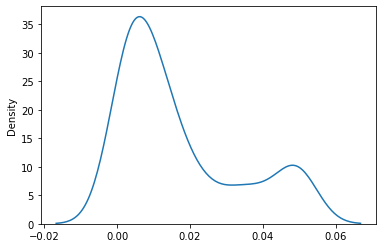

In [18]:
kl_df.loc[kl_df['kl']>0.05,'kl']=0.05
sns.kdeplot(x=kl_df['kl'].values)

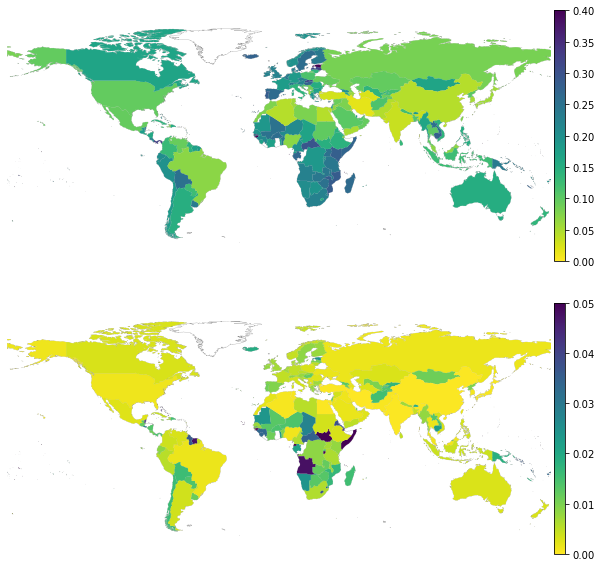

In [32]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.4)
gs = fig.add_gridspec(nrows=4, ncols=40)
ax0 = fig.add_subplot(gs[0:2, 0:39])
ax1 = fig.add_subplot(gs[0:2, 39:])
ax2= fig.add_subplot(gs[2:, 0:39])
ax3 = fig.add_subplot(gs[2:,39:])

plot_data=world_geo.merge(cnt_df,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax0, fig, world_geo, plot_data, 'prop','viridis_r',0.0,0.4,'Proportion')
ax0.margins(0)

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=0.4))
fig.colorbar(sm,cax=ax1)
ax1.margins(0)

plot_data=world_geo.merge(kl_df,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_worldmap(ax2, fig, world_geo, plot_data, 'kl','viridis_r',0.0,0.05,'kl')
ax2.margins(0)

sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=0, vmax=0.05))
fig.colorbar(sm,cax=ax3)
ax3.margins(0)
plt.savefig(colldep_path,bbox_inches='tight')

In [69]:
paf.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,label
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey],0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,"[United States, France]",[United States],0
2,30574691,[Russia],[Russia],83,2009,0.312,4,[Russia],[Russia],0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,[Spain],[Spain],0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,"[Germany, Spain]",[Spain],0


In [80]:
paf_exp = paf[['id','author_distinct','funder_distinct','discipline','year','label']
             ].explode('funder_distinct')

In [81]:
dislist=paf.discipline.unique()
dislist.sort()

calculate the KL value without international funding exchange. International funding exchange is defined as the international collaboration from both funding and authorship perspective. 

In [82]:
#remove the specific country from the record
def filter_profile(paf,paf_exp,cntry):
    removelist=paf_exp[(paf_exp.funder_distinct==cntry)&(paf_exp.label==1)].id.tolist()
    paf_filter=paf[~paf.id.isin(removelist)]
    return paf_filter

In [83]:
def cal_abscnt(raw_p,filter_p):
    #calculate the absolute count difference between raw profile and filtered profile
    raw_cnt=raw_p.groupby(['cntry','year'])['frac'].sum().reset_index(name='frac_raw')
    filter_cnt = filter_p.groupby(['cntry','year'])['frac'].sum().reset_index(name='frac_flt')
    meta = raw_cnt.merge(filter_cnt,on=['cntry','year'],how='left')
    meta['dcrs_p']=(meta['frac_raw']-meta['frac_flt'])/(meta['frac_raw'])
    return meta

In [84]:
def get_dis_distrbt_matrix(profile_df,year,dislist):
    result_df=profile_df[profile_df.year==year]
    result_df=result_df.pivot_table(index='cntry',columns='dis',values='frac',fill_value=0)
    result_df=result_df[dislist]
    result_df=result_df.div(result_df.sum(axis=1), axis=0)
    return result_df

In [86]:
def cal_kl(P,Q):
    sum=0
    for ind,item in enumerate(P):
        value_p=P[ind]
        value_q=Q[ind]
        if value_p!=0 and value_q!=0:
            sum=sum+(value_p*np.log(value_p/value_q))
    return sum

In [87]:
def kl_cntrys(raw_dis, flt_dis):
    result=[]
    for index, row in raw_dis.iterrows():
        cntry=index
        p=row.values
        try:
            q=flt_dis.loc[cntry,:].values
        except KeyError:
            q=[0 for x in np.arange(len(p))]
        kl_value=cal_kl(p,q)
        result.append([cntry,kl_value])
    result_df=pd.DataFrame(result, columns=['cntry','kl_value'])
    return result_df

In [88]:
raw_profile=pd.read_csv('raw_profile.csv')

#### calculate KL and absolute value of single country after removing cofunded paper that is funded by the specific country

In [91]:
cntrylist=['United States','China','Japan','South Korea','Germany','United Kingdom','EU','India','Canada','Spain']
yearlist=paf.year.unique()
abscnt= pd.DataFrame()
kl=pd.DataFrame()
for cntry in cntrylist:
    print(cntry)
    paf_filter=filter_profile(paf,paf_exp,cntry)
    ft_profile = construct_profile(paf_filter)
    
    #calculate the decrease in absolute publication count
    absdecrs= cal_abscnt(raw_profile,ft_profile)
    absdecrs['srce_cntry']=cntry
    abscnt=pd.concat([abscnt,absdecrs])
    for year in yearlist:
        raw_dis=get_dis_distrbt_matrix(raw_profile,year,dislist)
        flt_dis=get_dis_distrbt_matrix(ft_profile,year,dislist)
        kldev=kl_cntrys(flt_dis,raw_dis)
        kldev['year']=year
        kldev['srce_cntry']=cntry
        kl=pd.concat([kl,kldev])
    

United States
China
Japan
South Korea
Germany
United Kingdom
EU
India
Canada
Spain


In [16]:
kl_df.head()

,cntry,kl
0,Afghanistan,0.015048
1,Albania,0.003953
2,Algeria,0.000630
3,Andorra,0.047086
4,Angola,0.048017


In [17]:
kl2=pd.read_csv('klvalue.csv')

In [19]:
kl2=kl2.groupby(['srce_cntry'])['kl_value'].mean().reset_index()

In [21]:
kl2.head(10)

,srce_cntry,kl_value
0,Canada,0.001757
1,China,0.001662
2,EU,0.008827
3,Germany,0.002634
4,India,0.000898
5,Japan,0.001887
6,South Korea,0.001339
7,Spain,0.002269
8,United Kingdom,0.009331
9,United States,0.023871


In [22]:
meta=kl_df.merge(kl2,left_on='cntry',right_on='srce_cntry')
meta.head(10)

,cntry,kl,srce_cntry,kl_value
0,Canada,0.002938,Canada,0.001757
1,China,0.000296,China,0.001662
2,Germany,0.004883,Germany,0.002634
3,India,0.000268,India,0.000898
4,Japan,0.000736,Japan,0.001887
5,South Korea,0.000851,South Korea,0.001339
6,Spain,0.009435,Spain,0.002269
7,United Kingdom,0.007001,United Kingdom,0.009331
8,United States,0.001281,United States,0.023871


In [24]:
meta.sort_values(by='kl')

,cntry,kl,srce_cntry,kl_value
3,India,0.000268,India,0.000898
1,China,0.000296,China,0.001662
4,Japan,0.000736,Japan,0.001887
5,South Korea,0.000851,South Korea,0.001339
8,United States,0.001281,United States,0.023871
0,Canada,0.002938,Canada,0.001757
2,Germany,0.004883,Germany,0.002634
7,United Kingdom,0.007001,United Kingdom,0.009331
6,Spain,0.009435,Spain,0.002269


<AxesSubplot:xlabel='kl', ylabel='kl_value'>

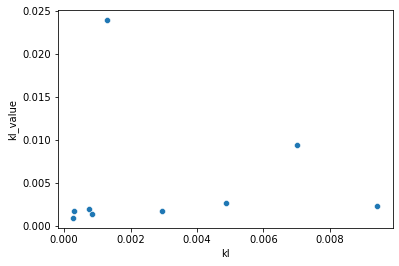

In [23]:
sns.scatterplot(x='kl',y='kl_value',data=meta)

In [92]:
abscnt.to_csv("countdecrease.csv",index=False)
kl.to_csv("klvalue.csv",index=False)

In [3]:
abscnt=pd.read_csv("countdecrease.csv")
kl_df=pd.read_csv('klvalue.csv')

In [4]:
abscnt.head()

,cntry,year,frac_raw,frac_flt,dcrs_p,srce_cntry
0,Afghanistan,2009,8.750000,6.750000,0.228571,United States
1,Afghanistan,2010,15.566667,15.366667,0.012848,United States
2,Afghanistan,2011,13.044444,11.777778,0.097104,United States
3,Afghanistan,2012,19.566667,19.566667,0.000000,United States
4,Afghanistan,2013,11.095833,10.845833,0.022531,United States


In [6]:
kl_df.head()

,cntry,kl_value,year,srce_cntry
0,Afghanistan,0.178133,2009,United States
1,Albania,0.003766,2009,United States
2,Algeria,0.000099,2009,United States
3,Andorra,0.000000,2009,United States
4,Angola,0.043368,2009,United States


In [7]:
flag_df=pd.read_csv("../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv",sep="\t")
flag_df.tail()

,WoS,ECI_Country,WB,Code
213,Burkina Faso,NaN,NaN,BFA
214,Guinea-Bissau,NaN,NaN,GNB
215,Liechtenstein,NaN,NaN,LIE
216,Niger,NaN,NaN,NER
217,EU,NaN,NaN,EU


In [8]:
abscnt = abscnt.merge(flag_df[['WoS','Code']],left_on='srce_cntry',right_on='WoS')
abscnt.head()

,cntry,year,frac_raw,frac_flt,dcrs_p,srce_cntry,WoS,Code
0,Afghanistan,2009,8.750000,6.750000,0.228571,United States,United States,USA
1,Afghanistan,2010,15.566667,15.366667,0.012848,United States,United States,USA
2,Afghanistan,2011,13.044444,11.777778,0.097104,United States,United States,USA
3,Afghanistan,2012,19.566667,19.566667,0.000000,United States,United States,USA
4,Afghanistan,2013,11.095833,10.845833,0.022531,United States,United States,USA


In [9]:
abscnt = abscnt[abscnt.cntry!=abscnt.srce_cntry]

In [10]:
abscnt['rank'] = abscnt.groupby(['cntry','year'])['dcrs_p'].rank('dense',ascending=False)

In [11]:
abshigh = abscnt[abscnt['rank']==1].groupby(['year','Code']).size().reset_index(name='count')

In [14]:
kl_df=kl_df[kl_df.kl_value!=0]
kl_df=kl_df[kl_df.cntry!=kl_df.srce_cntry]
kl_df['rank'] = kl_df.groupby(['cntry','year'])['kl_value'].rank('dense',ascending=False)

In [21]:
kl_df[(kl_df.cntry=='Singapore')&(kl_df.year==2009)].sort_values(by='kl_value')

,cntry,kl_value,year,srce_cntry,rank
14212,Singapore,0.000002,2009,India,10.0
18230,Singapore,0.000004,2009,Spain,9.0
16222,Singapore,0.000009,2009,Canada,8.0
4169,Singapore,0.000015,2009,Japan,7.0
8188,Singapore,0.000019,2009,Germany,6.0
6179,Singapore,0.000026,2009,South Korea,5.0
12204,Singapore,0.000052,2009,EU,4.0
10197,Singapore,0.000407,2009,United Kingdom,3.0
152,Singapore,0.000450,2009,United States,2.0
2160,Singapore,0.000632,2009,China,1.0


In [44]:
abscnt.head()

,cntry,year,frac_raw,frac_flt,dcrs_p,srce_cntry,WoS,Code,rank
0,Afghanistan,2009,8.750000,7.750000,0.114286,United States,United States,USA,1.0
1,Afghanistan,2010,15.566667,15.366667,0.012848,United States,United States,USA,3.0
2,Afghanistan,2011,13.044444,12.277778,0.058773,United States,United States,USA,1.0
3,Afghanistan,2012,19.566667,19.566667,0.000000,United States,United States,USA,1.0
4,Afghanistan,2013,11.095833,11.095833,0.000000,United States,United States,USA,2.0


In [23]:
kl_df=kl_df.merge(flag_df[['WoS','Code']],left_on='srce_cntry',right_on='WoS')
kl_df.head()

,cntry,kl_value,year,srce_cntry,rank,WoS,Code
0,Afghanistan,0.178133,2009,United States,1.0,United States,USA
1,Albania,0.003766,2009,United States,2.0,United States,USA
2,Algeria,0.000099,2009,United States,4.0,United States,USA
3,Angola,0.043368,2009,United States,1.0,United States,USA
4,Argentina,0.001075,2009,United States,1.0,United States,USA


In [25]:
klhigh=kl_df[kl_df['rank']==1].groupby(['year','Code']).size().reset_index(name='count')

In [26]:
colordict={'USA':'#A6341B','CHN':'#F2506E','EU':"#0CC7E8",'DEU':'#00FFD6','GBR':'#0CE87E','ESP':'#0D93FF',
          'CAN':'#8DB202','IND':'#C3B6F2','JPN':'#CAB4D9','KOR':'#E15EF2'}

In [41]:
# set the font name for a font family
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']

In [46]:
abshigh

,year,Code,count
0,2009,CAN,16
1,2009,CHN,17
2,2009,DEU,23
3,2009,ESP,16
4,2009,EU,57
...,...,...,...
95,2018,GBR,17
96,2018,IND,5
97,2018,JPN,7
98,2018,KOR,6


In [53]:
abscnt[abscnt.year==2018].groupby(['Code'])['dcrs_p'].mean().index

Index(['CAN', 'CHN', 'DEU', 'ESP', 'EU', 'GBR', 'IND', 'JPN', 'KOR', 'USA'], dtype='object', name='Code')

<ipython-input-56-9b3aef97a647>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0][1].set_yticklabels(['{:,.2%}'.format(x) for x in vals])


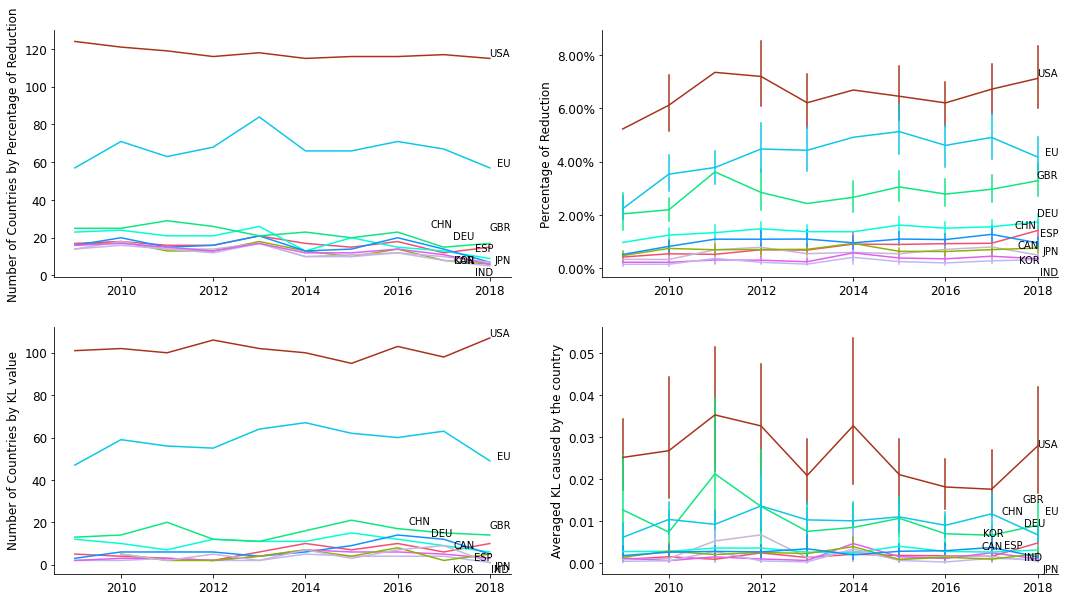

In [56]:
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(18,10))

labellist=abshigh[abshigh.year==2018].Code.values
ylabel=abshigh[abshigh.year==2018]['count'].values
sns.lineplot(x='year',y='count',hue='Code',data=abshigh,ax=ax[0][0],legend=False,palette=colordict)
texts = [ax[0][0].text(2021, ylabel[i], labellist[i]) for i in range(len(labellist))]
adjust_text(texts, arrowprops=dict(arrowstyle='->'),ax=ax[0][0])
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
ax[0][0].tick_params(axis='both', which='major', labelsize=12)
ax[0][0].set_ylabel("Number of Countries by Percentage of Reduction",fontsize=12)
ax[0][0].set_xlabel("")

labellist=abscnt[abscnt.year==2018].groupby(['Code'])['dcrs_p'].mean().index
ylabel=abscnt[abscnt.year==2018].groupby(['Code'])['dcrs_p'].mean().values
sns.lineplot(x='year',y='dcrs_p',err_style='bars',ci=95,hue='Code',data=abscnt,ax=ax[0][1],legend=False,palette=colordict)
vals = ax[0][1].get_yticks()
ax[0][1].set_yticklabels(['{:,.2%}'.format(x) for x in vals])
texts = [ax[0][1].text(2021, ylabel[i], labellist[i]) for i in range(len(labellist))]
adjust_text(texts, arrowprops=dict(arrowstyle='->'),ax=ax[0][1])
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
ax[0][1].tick_params(axis='both', which='major', labelsize=12)
ax[0][1].set_ylabel("Percentage of Reduction",fontsize=12)
ax[0][1].set_xlabel("")

labellist=klhigh[klhigh.year==2018].Code.values
ylabel=klhigh[klhigh.year==2018]['count'].values
sns.lineplot(x='year',y='count',hue='Code',data=klhigh,ax=ax[1][0],legend=False,palette=colordict)
texts = [ax[1][0].text(2021, ylabel[i], labellist[i]) for i in range(len(labellist))]
adjust_text(texts, arrowprops=dict(arrowstyle='->'),ax=ax[1][0])
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].tick_params(axis='both', which='major', labelsize=12)
ax[1][0].set_ylabel("Number of Countries by KL value",fontsize=12)
ax[1][0].set_xlabel("")



labellist=['USA','GBR','EU','CHN','DEU','CAN','ESP','KOR','IND','JPN']
ylist = [0.027,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001,0]
sns.lineplot(x='year',y='kl_value',err_style='bars',ci=95,hue='Code',data=kl_df,legend=False,ax=ax[1][1],palette=colordict)
texts = [ax[1][1].text(2021, ylist[i], labellist[i]) for i in range(len(labellist))]
adjust_text(texts, arrowprops=dict(arrowstyle='->'),ax=ax[1][1])
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].tick_params(axis='both', which='major', labelsize=12)
ax[1][1].set_ylabel("Averaged KL caused by the country",fontsize=12)
ax[1][1].set_xlabel("")


plt.savefig(fig_path,bbox_inches='tight')


In [34]:
kl_df.head()

,cntry,kl_value,year,srce_cntry,rank,WoS,Code
0,Afghanistan,0.178133,2009,United States,1.0,United States,USA
1,Albania,0.003766,2009,United States,2.0,United States,USA
2,Algeria,0.000099,2009,United States,4.0,United States,USA
3,Angola,0.043368,2009,United States,1.0,United States,USA
4,Argentina,0.001075,2009,United States,1.0,United States,USA


In [35]:
kl_df[kl_df.year==2018].groupby('Code')['kl_value'].mean().sort_values(ascending=False)

Code
USA    0.027861
GBR    0.008977
EU     0.006687
CHN    0.004760
DEU    0.003091
CAN    0.002187
ESP    0.001449
KOR    0.000968
IND    0.000787
JPN    0.000464
Name: kl_value, dtype: float64

Text(0.5, 69.00000000000009, '')

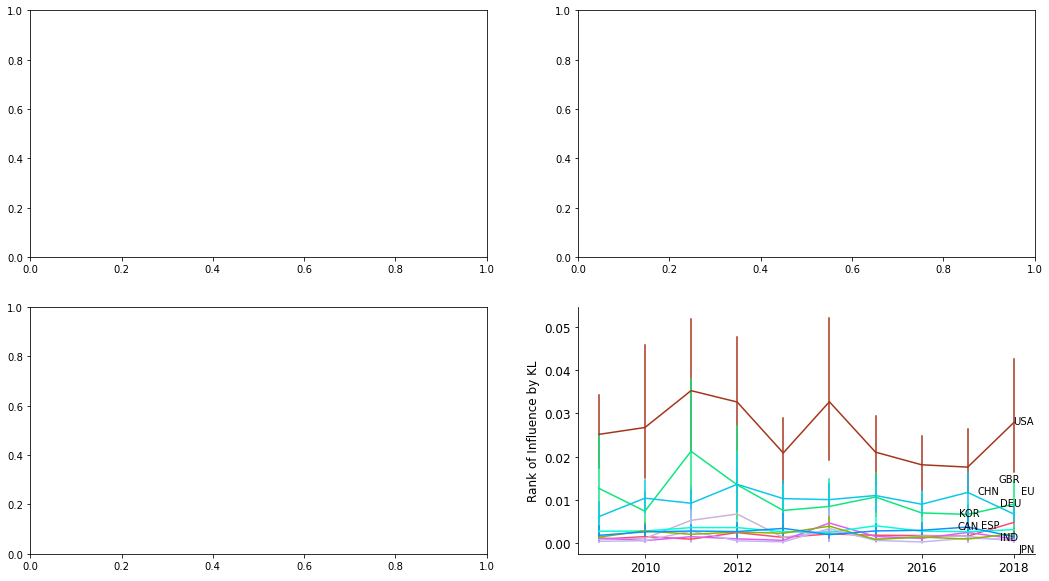

In [37]:
fig, ax=plt.subplots(nrows=2,ncols=2,figsize=(18,10))




In [27]:
kl_df.head()

,cntry,kl_value,year,srce_cntry,rank,WoS,Code
0,Afghanistan,0.178133,2009,United States,1.0,United States,USA
1,Albania,0.003766,2009,United States,2.0,United States,USA
2,Algeria,0.000099,2009,United States,4.0,United States,USA
3,Angola,0.043368,2009,United States,1.0,United States,USA
4,Argentina,0.001075,2009,United States,1.0,United States,USA


In [66]:
def cal_kl(P,Q):
    sum=0
    for ind,item in enumerate(P):
        value_p=P[ind]
        value_q=Q[ind]
        if value_p!=0 and value_q!=0:
            print(ind)
            print(np.log(value_p/value_q))
            sum=sum+(value_p*np.log(value_p/value_q))
    return sum

In [30]:
paf_filter=filter_profile(paf,paf_exp,'United States')
ft_profile = construct_profile(paf_filter)

In [8]:
#label out the papers that have funding exchange. Here cofund is defined as funding exchange
#funding exchange is collaboration from funding and authorship perspective.
def assign_label(authorlist, funderlist):
    label=1
    if funderlist=='Not-Funded':
        label=0
    elif len(authorlist)==1 and set(authorlist)==set(funderlist):
        label=0
    return label
paf['fundflow']=paf.apply(
    lambda x: assign_label(x.author_distinct, x.funder_distinct),axis=1)
paf['coll']=paf['author_distinct'].apply(
    lambda x: 1 if len(x)>1 else 0)
paf.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,fundflow,coll
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey],0,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,"[United States, France]",[United States],1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,[Russia],[Russia],0,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,[Spain],[Spain],0,0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,"[Spain, Germany]",[Spain],1,1


In [6]:
cntry_raw=pubs_author_funder[
    ['id','author_distinct','discipline','rel_citation','fundflow']].explode('author_distinct')
cntry_filter=cntry_raw[cntry_raw.fundflow==0]

In [7]:
cnt_raw=cntry_raw.groupby(['author_distinct']).size().reset_index(name='cnt_raw')
cnt_filter=cntry_filter.groupby(['author_distinct']).size().reset_index(name='cnt_filter')

In [8]:
cnt_change=cnt_raw.merge(cnt_filter, on='author_distinct',how='left')
cnt_change=cnt_change.fillna(0)
cnt_change['cnt_decreased']=(cnt_change['cnt_raw']-cnt_change['cnt_filter'])/cnt_change['cnt_raw']
cnt_change.head()

,author_distinct,cnt_raw,cnt_filter,cnt_decreased
0,Afghanistan,399,220.0,0.448622
1,Albania,1424,1060.0,0.255618
2,Algeria,25049,20141.0,0.195936
3,Andorra,69,34.0,0.507246
4,Angola,482,193.0,0.599585


In [9]:
cnt_change.sort_values(by='cnt_decreased',ascending=False)

,author_distinct,cnt_raw,cnt_filter,cnt_decreased
44,Crimea,5,0.0,1.000000
134,Niue,5,0.0,1.000000
158,Sao Tome & Principe,36,5.0,0.861111
200,Vatican,202,35.0,0.826733
76,Guinea-Bissau,333,59.0,0.822823
...,...,...,...,...
2,Algeria,25049,20141.0,0.195936
72,Grenada,930,769.0,0.173118
82,India,546864,459578.0,0.159612
189,Turkey,241651,210290.0,0.129778


In [10]:
dislist=pubs_author_funder.discipline.unique()
dislist.sort()
def get_dis_distribution(result_df):
    result_df=result_df.groupby(['author_distinct','discipline']).size().reset_index(name='count')
    result_df=result_df.pivot_table(index='author_distinct',columns='discipline',values='count',fill_value=0)
    result_df=result_df[dislist]
    result_df=result_df.div(result_df.sum(axis=1), axis=0)
    return result_df

In [11]:
dis_raw=get_dis_distribution(cntry_raw)
dis_filter=get_dis_distribution(cntry_filter)

In [11]:
cntry_coll=pubs_author_funder[pubs_author_funder.coll==0]
cntry_coll.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,fundflow,coll
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey],0,0
2,30574691,[Russia],[Russia],83,2009,0.312,4,[Russia],[Russia],0,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,[Spain],[Spain],0,0
5,30585101,[United States],[United States],89,2009,1.230,9,[United States],[United States],0,0
6,30585102,[United States],[United States],89,2009,0.137,1,[United States],[United States],0,0


In [12]:
cntry_coll=cntry_coll[['author_distinct','discipline']]
cntry_coll=cntry_coll.explode('author_distinct')
cntry_coll.head()

,author_distinct,discipline
0,Turkey,77
2,Russia,83
3,Spain,89
5,United States,89
6,United States,89


In [13]:
dis_coll=get_dis_distribution(cntry_coll)
dis_coll.head()

discipline,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
author_distinct,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.071429,0.000000,0.000000,0.035714,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Albania,0.029484,0.022113,0.007371,0.002457,0.002457,0.004914,0.004914,0.002457,0.000000,0.002457,...,0.007371,0.00000,0.000000,0.000000,0.000000,0.014742,0.000000,0.002457,0.000000,0.00000
Algeria,0.020330,0.013553,0.002357,0.006678,0.004321,0.001080,0.002946,0.003929,0.000196,0.000491,...,0.012080,0.00275,0.032803,0.010509,0.016009,0.069436,0.000687,0.011589,0.028776,0.01375
Andorra,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Angola,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [12]:
def cal_kl(P,Q):
    sum=0
    for ind,item in enumerate(P):
        value_p=P[ind]
        value_q=Q[ind]
        if value_p!=0 and value_q!=0:
            sum=sum+(value_p*np.log(value_p/value_q))
    return sum

In [13]:
def kl_cntrys(pmatrix, qmatrix,colname):
    result=[]
    for index, row in pmatrix.iterrows():
        cntry=index
        p=row.values
        q=qmatrix.loc[cntry,:].values
        kl_value=cal_kl(p,q)
        result.append([cntry,kl_value])
    result_df=pd.DataFrame(result, columns=['cntry',colname])
    return result_df

In [16]:
kl_coll=kl_cntrys(dis_coll, dis_raw,'kl_coll')
kl_coll.head()

,cntry,kl_coll
0,Afghanistan,0.921152
1,Albania,0.334128
2,Algeria,0.034224
3,Andorra,2.847812
4,Angola,1.609828


In [14]:
kl_cnt=kl_cntrys(dis_filter,dis_raw,'kl_cnt' )
kl_cnt.head()

,cntry,kl_cnt
0,Afghanistan,0.102044
1,Albania,0.037486
2,Algeria,0.008841
3,Andorra,0.434989
4,Angola,0.165932


In [17]:
meta=kl_cnt.merge(cnt_change, left_on='cntry',right_on='author_distinct')
meta['cofund_rank']=meta['kl_cnt'].rank(ascending=False, method='min')
#meta=meta.merge(kl_coll, on='cntry')
meta.head()

,cntry,kl_cnt,author_distinct,cnt_raw,cnt_filter,cnt_decreased,cofund_rank
0,Afghanistan,0.102044,Afghanistan,399,220.0,0.448622,92.0
1,Albania,0.037486,Albania,1424,1060.0,0.255618,159.0
2,Algeria,0.008841,Algeria,25049,20141.0,0.195936,200.0
3,Andorra,0.434989,Andorra,69,34.0,0.507246,14.0
4,Angola,0.165932,Angola,482,193.0,0.599585,59.0


In [23]:
meta.head()

,cntry,kl_cnt,author_distinct,cnt_raw,cnt_filter,cnt_decreased,cofund_rank,WoS,Code,continent
0,Afghanistan,0.102044,Afghanistan,399,220.0,0.448622,92.0,Afghanistan,AFG,Asia
1,Albania,0.037486,Albania,1424,1060.0,0.255618,159.0,Albania,ALB,Europe
2,Algeria,0.008841,Algeria,25049,20141.0,0.195936,200.0,Algeria,DZA,Africa
3,Andorra,0.434989,Andorra,69,34.0,0.507246,14.0,Andorra,AND,Europe
4,Angola,0.165932,Angola,482,193.0,0.599585,59.0,Angola,AGO,Africa


In [20]:
cntry_info=pd.read_csv(cntry_info_path)
cntry_info=cntry_info[['country_iso_alpha','continent']]
cntry_info.columns=['Code','continent']
cntry_info.head()

,Code,continent
0,AFG,Asia
1,ALB,Europe
2,DZA,Africa
3,ASM,Oceania
4,AND,Europe


In [21]:
flag_df=pd.read_csv(flag_path, sep="\t")
flag_df=flag_df[['WoS','Code']]
flag_df.head()

,WoS,Code
0,Albania,ALB
1,Algeria,DZA
2,Angola,AGO
3,Argentina,ARG
4,Australia,AUS


In [22]:
meta=meta.merge(flag_df, left_on='cntry', right_on='WoS')
meta=meta.merge(cntry_info,on='Code')

In [60]:
colordict={'North America':'#3F63A6','South America':'#EB8B10','Europe':'#A64208',
          'Africa':'#327A2D','Oceania':'#B3E0F2','Asia':'#FF8C64'}

In [63]:
meta['cnt_rank']=meta['cnt_decreased'].rank(ascending=False,method='min')
meta['cofund_rank']=meta['kl_cnt'].rank(ascending=False, method='min')
meta['coll_rank']=meta['kl_coll'].rank(ascending=False, method='min')
meta.sort_values(by='coll_rank')

,cntry,kl_cnt,author_distinct,cnt_raw,cnt_filter,cnt_decreased,kl_coll,WoS,Code,continent,cnt_log,cnt_rank,cofund_rank,coll_rank
30,Cape Verde,0.364546,Cape Verde,188,61.0,0.675532,5.236442,Cape Verde,CPV,Africa,2.274158,16.0,8.0,1.0
68,Guinea-Bissau,0.202123,Guinea-Bissau,333,59.0,0.822823,4.198705,Guinea-Bissau,GNB,Africa,2.522444,1.0,27.0,2.0
105,Marshall Islands,0.753168,Marshall Islands,27,12.0,0.555556,3.295837,Marshall Islands,MHL,Oceania,1.431364,70.0,2.0,3.0
32,Chad,0.172285,Chad,216,99.0,0.541667,3.149737,Chad,TCD,Africa,2.334454,74.0,41.0,4.0
106,Mauritania,0.244918,Mauritania,241,98.0,0.593361,3.069814,Mauritania,MRT,Africa,2.382017,51.0,16.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Turkey,0.008674,Turkey,241651,210290.0,0.129778,0.013333,Turkey,TUR,Asia,5.383189,185.0,183.0,182.0
153,South Korea,0.010800,South Korea,490587,372829.0,0.240035,0.012859,South Korea,KOR,Asia,5.690716,179.0,180.0,183.0
34,China,0.004932,China,2365486,1846403.0,0.219440,0.006042,China,CHN,Asia,6.373920,181.0,184.0,184.0
74,India,0.004396,India,546864,459578.0,0.159612,0.005976,India,IND,Asia,5.737879,184.0,185.0,185.0


In [64]:
def plot_worldmap(ax, fig, basemap, data, plotcolumn, cmap, vmin, vmax,legend_title):
    """plot a basemap and color the country based on the column passed into
    """

    basemap.plot(ax=ax, linewidth=0.25, edgecolor="#8C8C8C", facecolor="#ffffff")
    data.plot(column=plotcolumn, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    clb = fig.colorbar(sm, cax=cax)
    clb.ax.set_title(legend_title)
    return fig, ax

In [65]:
world_geo=gp.read_file("../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp")
world_geo=world_geo[['WoS','Code','geometry']]
world_geo=world_geo[world_geo.WoS!='Antarctica']
world_geo.head()

,WoS,Code,geometry
0,Zimbabwe,ZWE,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,ZMB,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,YEM,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."
3,Vietnam,VNM,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ..."
4,Venezuela,VEN,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9..."


In [66]:
plot_data=world_geo.merge(meta,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
plot_data.columns

Index(['WoS_x', 'Code_x', 'geometry', 'cntry', 'kl_cnt', 'author_distinct',
       'cnt_raw', 'cnt_filter', 'cnt_decreased', 'kl_coll', 'WoS_y', 'Code_y',
       'continent', 'cnt_log', 'cnt_rank', 'cofund_rank', 'coll_rank'],
      dtype='object')

In [108]:
from matplotlib import gridspec

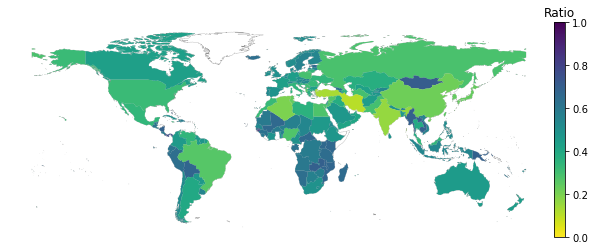

In [113]:
fig, ax=plt.subplots(figsize=(10,6))
fig, ax = plot_worldmap(ax, fig, world_geo, plot_data, 'cnt_decreased','viridis_r',0,1,'Ratio')
plt.savefig("results/decreased_ratio.pdf",bbox_inches='tight')

In [70]:
plot_data.columns

Index(['WoS_x', 'Code_x', 'geometry', 'cntry', 'kl_cnt', 'author_distinct',
       'cnt_raw', 'cnt_filter', 'cnt_decreased', 'kl_coll', 'WoS_y', 'Code_y',
       'continent', 'cnt_log', 'cnt_rank', 'cofund_rank', 'coll_rank'],
      dtype='object')

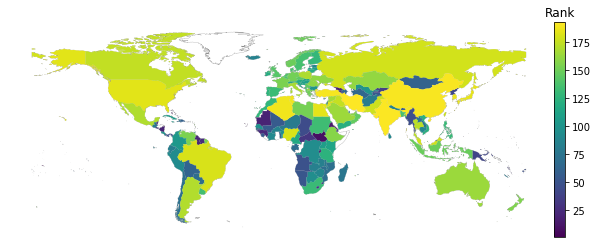

In [77]:
fig, ax=plt.subplots(figsize=(10,6))
fig, ax = plot_worldmap(ax, fig, world_geo, plot_data, 'cofund_rank','viridis',1,193,'Rank')
plt.savefig("results/kl_cofund.pdf",bbox_inches='tight')

In [97]:
meta['cnt_log']=np.log(meta['cnt_raw'])
meta.head()

,cntry,kl_cnt,author_distinct,cnt_raw,cnt_filter,cnt_decreased,kl_coll,WoS,Code,continent,cnt_log,cnt_rank,cofund_rank,coll_rank
0,Afghanistan,0.102044,Afghanistan,399,220.0,0.448622,0.921152,Afghanistan,AFG,Asia,5.988961,124.0,76.0,42.0
1,Albania,0.037486,Albania,1424,1060.0,0.255618,0.334128,Albania,ALB,Europe,7.261225,176.0,141.0,85.0
2,Algeria,0.008841,Algeria,25049,20141.0,0.195936,0.034224,Algeria,DZA,Africa,10.128589,182.0,182.0,166.0
3,Andorra,0.434989,Andorra,69,34.0,0.507246,2.847812,Andorra,AND,Europe,4.234107,96.0,7.0,6.0
4,Angola,0.165932,Angola,482,193.0,0.599585,1.609828,Angola,AGO,Africa,6.177944,47.0,45.0,21.0


In [145]:
cit_raw=cntry_raw.groupby('author_distinct')['rel_citation'].mean().reset_index(name='cit_raw')
cit_filter=cntry_filter.groupby('author_distinct')['rel_citation'].mean().reset_index(name='cit_filter')
cit_filter.head()

,author_distinct,cit_filter
0,Afghanistan,1.489255
1,Albania,0.519240
2,Algeria,0.660101
3,Andorra,0.757676
4,Angola,0.591259


In [148]:
cit_change=cit_raw.merge(cit_filter, on='author_distinct',how='left')
cit_change=cit_change.fillna(0)
cit_change['ratio']=(cit_change['cit_raw']-cit_change['cit_filter'])/(cit_change['cit_raw'])
cit_change.head()

,author_distinct,cit_raw,cit_filter,ratio
0,Afghanistan,2.906188,1.489255,0.487557
1,Albania,0.764188,0.519240,0.320534
2,Algeria,0.800310,0.660101,0.175193
3,Andorra,0.833000,0.757676,0.090424
4,Angola,1.138037,0.591259,0.480457
